In [24]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from thop import  clever_format

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
ESM_8M = "facebook/esm2_t6_8M_UR50D"
ESM_35M = "facebook/esm2_t12_35M_UR50D"
ESM_150M = "facebook/esm2_t30_150M_UR50D"
ESM_650M = "facebook/esm2_t33_650M_UR50D"
ESM_3B = "facebook/esm2_t36_3B_UR50D"
MODELS = [ESM_8M, ESM_35M, ESM_150M, ESM_650M, ESM_3B]

In [26]:
flops = []
memory = []
accuracy = []
seql = []
latency_df = []
gpu_util_df = []
for MODEL in MODELS: 
    mpath = MODEL.split('/')[1]
    print(MODEL)

    _flops = np.load(mpath + 'macs.npy')
    _memory = np.load(mpath + 'memory.npy')
    _accuracy = np.load(mpath + 'accuracy.npy')
    _seql = np.load(mpath + 'seql.npy')
    _latency_df = pd.read_csv("csv/" + mpath + '_latency', index_col=False )
    _gpu_util_df = pd.read_csv("csv/" + mpath + '_gpu_slen', index_col=False)

    # Preprocess flops and memory 
    t_flops = []
    t_memory = []

    for f in _flops:
        t_flops.append(2 * f / 1000000000)

    for m in _memory:
        t_memory.append(m / 1000000000)

    _flops = np.array(t_flops)
    _memory = np.array(t_memory)

    flops.append(_flops)
    memory.append(_memory)
    accuracy.append(_accuracy)
    seql.append(_seql)
    latency_df.append(_latency_df)
    gpu_util_df.append(_gpu_util_df)

facebook/esm2_t6_8M_UR50D
facebook/esm2_t12_35M_UR50D
facebook/esm2_t30_150M_UR50D
facebook/esm2_t33_650M_UR50D
facebook/esm2_t36_3B_UR50D


In [27]:
gpu_util_df[4].head()

,Unnamed: 0,timestamp,tag,duration,nvidia_gpu_0
0,0,1.712412e+09,run,9.098918,1222928
1,1,1.712412e+09,run,1.560977,237764
2,2,1.712412e+09,run,0.182403,5747
3,3,1.712412e+09,run,0.696309,108258
4,4,1.712412e+09,run,0.723512,118677


# Plotters

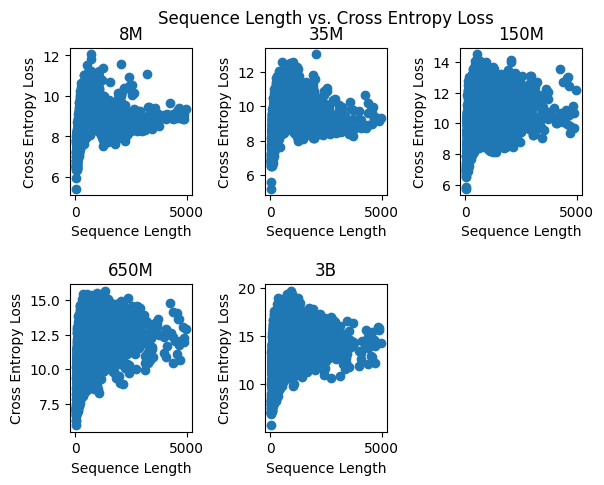

In [28]:
# Create a scatter plot\
for i in range(0, len(MODELS)):
    plt.subplot(2, 3, i + 1)
    plt.scatter(seql[i], accuracy[i])

    # Label the axes
    plt.xlabel('Sequence Length')
    plt.ylabel('Cross Entropy Loss')
    plt.title(MODELS[i].split('/')[1].split('_')[2])
    
# Add a title
plt.suptitle('Sequence Length vs. Cross Entropy Loss')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.6, 
                    hspace=0.6)
plt.show()

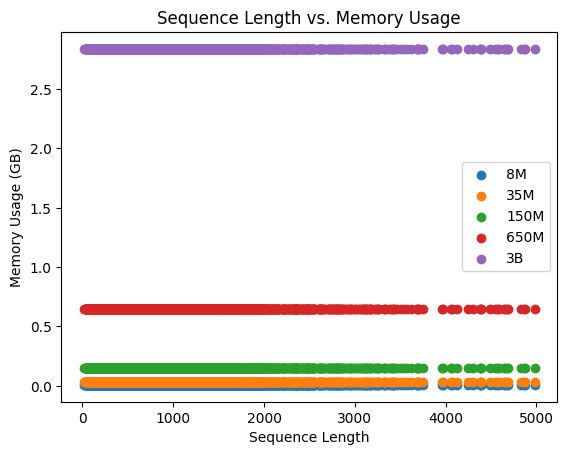

In [29]:
# Create a scatter plot
for i in range(0, len(MODELS)):
    plt.scatter(seql[i], memory[i], label = MODELS[i].split('/')[1].split('_')[2])

    # Label the axes
    plt.xlabel('Sequence Length')
    plt.ylabel('Memory Usage (GB)')

    # Add a title
    plt.title('Sequence Length vs. Memory Usage')

# Display the plot
plt.legend()
plt.show()

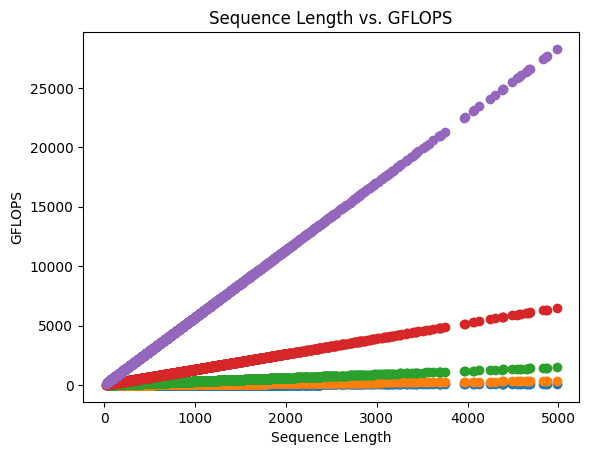

In [30]:
# Create a scatter plot
for i in range(0, len(MODELS)):
    plt.scatter(seql[i], flops[i])

    # Label the axes
    plt.xlabel('Sequence Length')
    plt.ylabel('GFLOPS')

    # Add a title
    plt.title('Sequence Length vs. GFLOPS')

# Display the plot
plt.show()

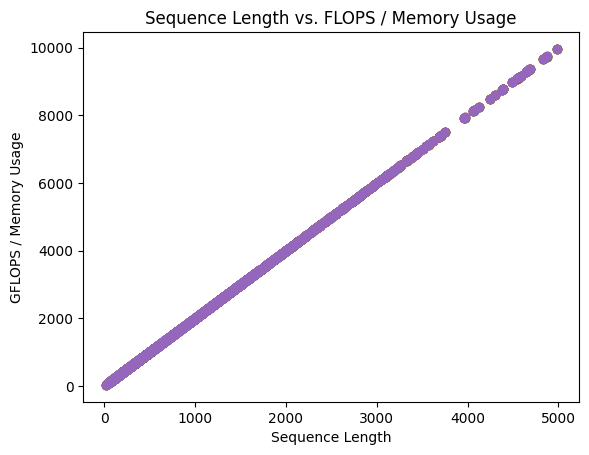

In [31]:
# Create a scatter plot
for i in range(0, len(MODELS)):
    plt.scatter(seql[i], flops[i] / memory[i])

    # Label the axes
    plt.xlabel('Sequence Length')
    plt.ylabel('GFLOPS / Memory Usage')

    # Add a title
    plt.title('Sequence Length vs. FLOPS / Memory Usage')

# Display the plot
plt.show()

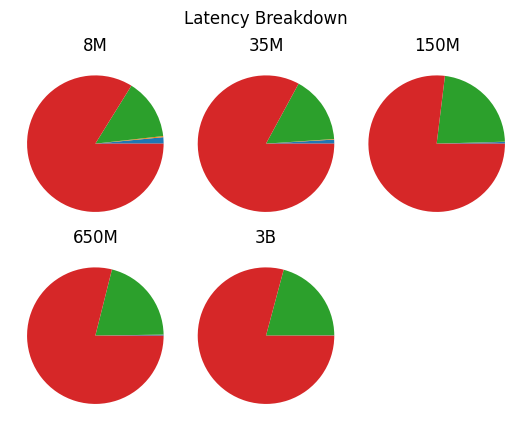

In [32]:
for i in range(0, len(MODELS)): 
    plt.subplot(2, 3, i + 1)
    latency_sums = latency_df[i][['tokenization', 'move_inputs_to_gpu', 'model_process', 'cross_entropy_loss']].mean()
    pd.to_numeric(latency_sums,  errors='coerce')
    plt.title(MODELS[i].split('/')[1].split('_')[2])

    
    plt.pie(latency_sums.values.astype(float))

# Add a title
plt.suptitle('Latency Breakdown')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0, 
                    hspace=0)
plt.show()

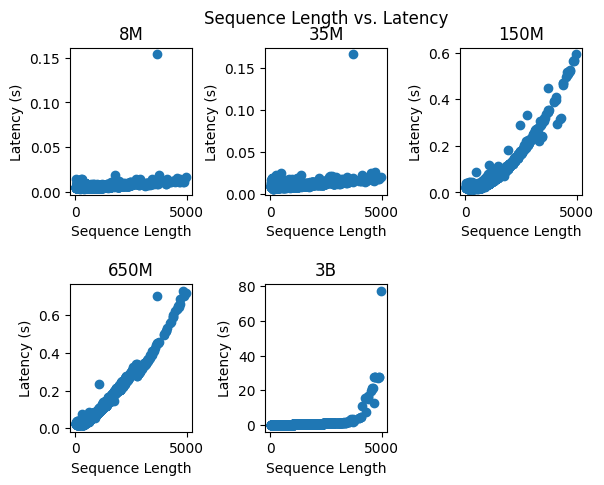

In [33]:
# Create a scatter plot\
for i in range(0, len(MODELS)):
    plt.subplot(2, 3, i + 1)
    plt.scatter(seql[i], latency_df[i][['model_process']] / 1000000000)

    # Label the axes
    plt.xlabel('Sequence Length')
    plt.ylabel('Latency (s)')
    plt.title(MODELS[i].split('/')[1].split('_')[2])
    
# Add a title
plt.suptitle('Sequence Length vs. Latency')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.6, 
                    hspace=0.6)
plt.show()

In [34]:
def general_function(x, a, p, b):
    return a * x**p  + b

[9.37091319e-10 1.92424453e+00 5.32437977e-03]
[2.24378014e-10 2.12204813e+00 9.64428023e-03]
[2.99314069e-08 1.97130552e+00 1.75585974e-02]
[4.67460517e-06 1.39957063e+00 1.29066555e-02]
[7.08942451e-16 4.50000000e+00 1.17380816e-01]


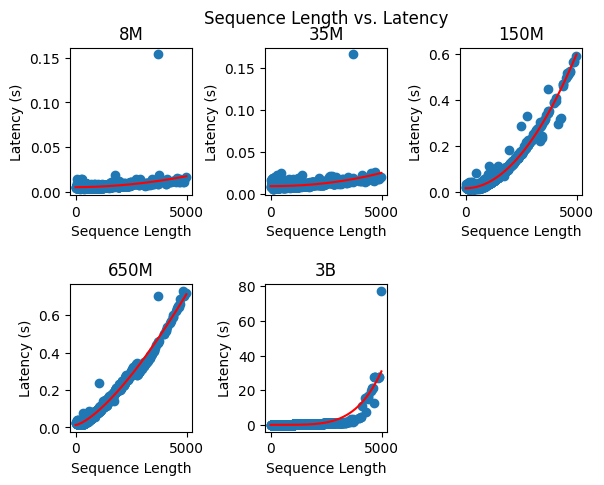

In [49]:
# Create a scatter plot\
for i in range(0, len(MODELS)):
    plt.subplot(2, 3, i + 1)
    X = seql[i]
    Y = latency_df[i][['model_process']] / 1000000000
    # Fit the curve
    popt, pcov = curve_fit(general_function, X, np.reshape(Y.values, (-1)), bounds=(0, 4.75))
    print(popt)

    plt.scatter(X, Y)
    _x = [i for i in range(0, max(seql[i]))]
    plt.plot(_x, general_function(_x, *popt), 'r-')

    # Label the axes
    plt.xlabel('Sequence Length')
    plt.ylabel('Latency (s)')
    plt.title(MODELS[i].split('/')[1].split('_')[2])
    
# Add a title
plt.suptitle('Sequence Length vs. Latency')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.6, 
                    hspace=0.6)
plt.show()

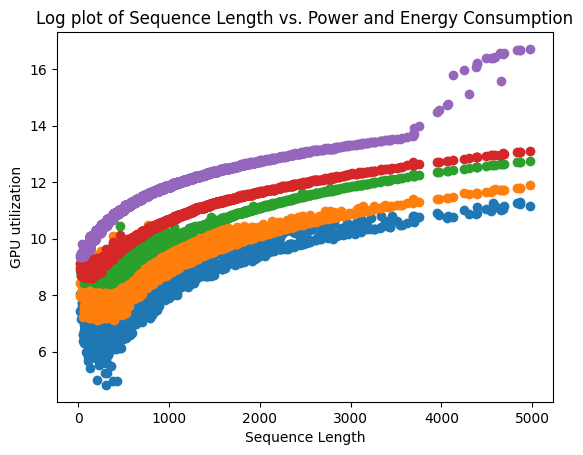

In [10]:
for i in range(0, len(MODELS)):
    duration = gpu_util_df[i]["duration"] * 100000

    # Create a scatter plot
    plt.scatter(seql[i], np.log(duration))

    # Label the axes
    plt.xlabel('Sequence Length')
    plt.ylabel('GPU utilization')

    # Add a title
    plt.title('Log plot of Sequence Length vs. Power and Energy Consumption')

# Display the plot
plt.show()

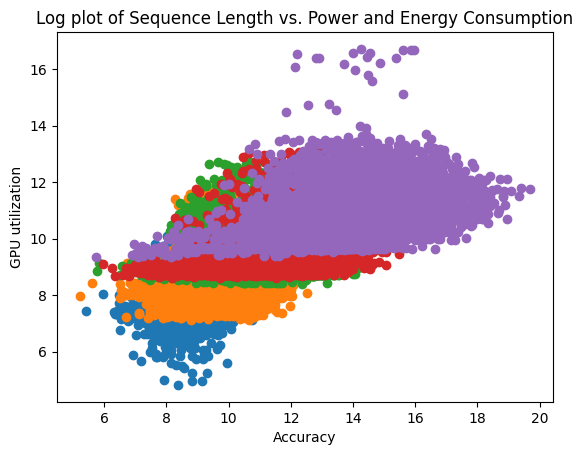

In [11]:
for i in range(0, len(MODELS)):
    duration = gpu_util_df[i]["duration"] * 100000

    # Create a scatter plot
    plt.scatter(accuracy[i], np.log(duration))

    # Label the axes
    plt.xlabel('Accuracy')
    plt.ylabel('GPU utilization')

    # Add a title
    plt.title('Log plot of Sequence Length vs. Power and Energy Consumption')

# Display the plot
plt.show()